In [ ]:
pip install seaborn

In [13]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from keras import layers
from keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [14]:
DATASET_PATH = 'data_set'

data_dir = pathlib.Path(DATASET_PATH)

In [15]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
print('Commands:', commands)

Commands: ['ልበ_ብርሀን' 'መልስ' 'አሳልፍ' 'አቁም' 'አቋርጥ' 'ክፈት' 'ዝጋ' 'ድምፅ' 'ጀምር' 'ፅሁፍ']


In [16]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 170 files belonging to 10 classes.
Using 136 files for training.
Using 34 files for validation.

label names: ['ልበ_ብርሀን' 'መልስ' 'አሳልፍ' 'አቁም' 'አቋርጥ' 'ክፈት' 'ዝጋ' 'ድምፅ' 'ጀምር' 'ፅሁፍ']


In [17]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [18]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [19]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [20]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


In [21]:
label_names[[1,1,3,0]]

array(['መልስ', 'መልስ', 'አቁም', 'ልበ_ብርሀን'], dtype='<U7')

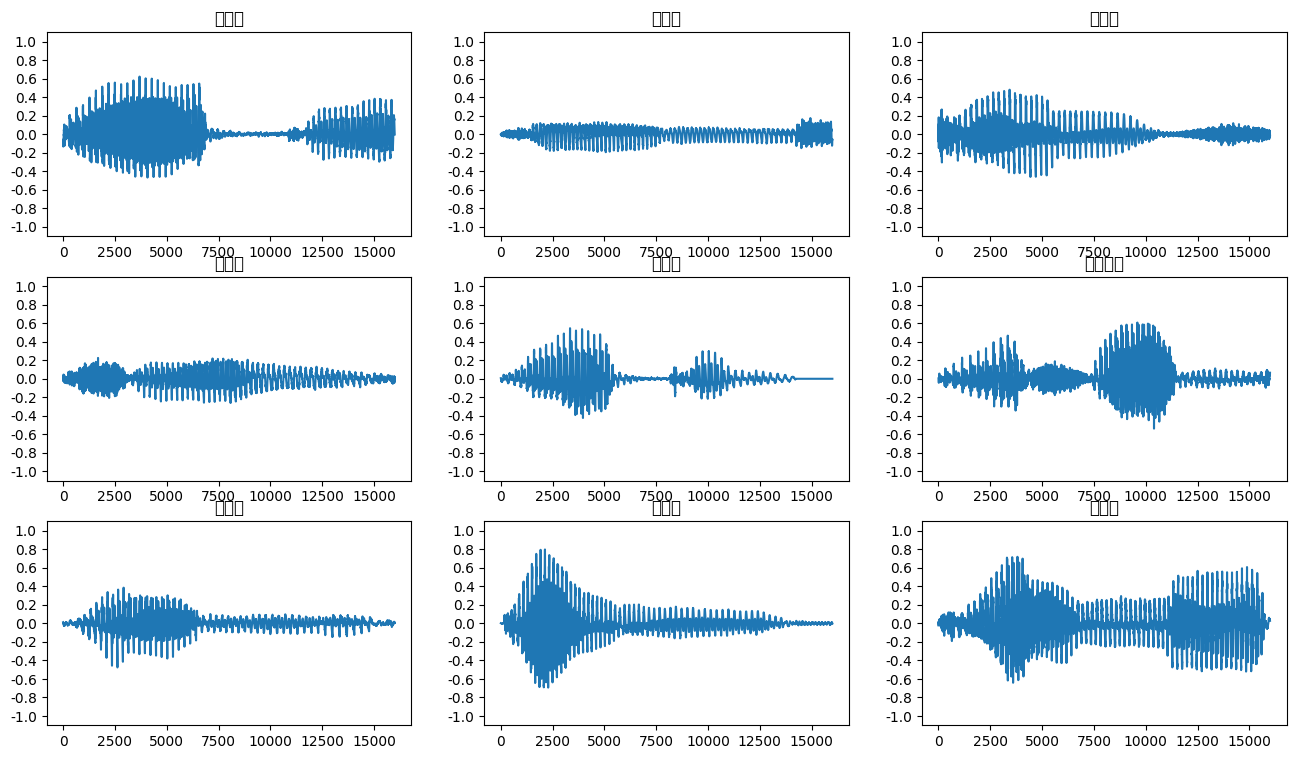

In [22]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
  if i>=n:
    break
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(example_audio[i].numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label_names[example_labels[i]]
  ax.set_title(label)
  ax.set_ylim([-1.1,1.1])

plt.rc('axes', unicode_minus=False)

In [23]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [24]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: አቁም
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: ጀምር
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: ድምፅ
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [25]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

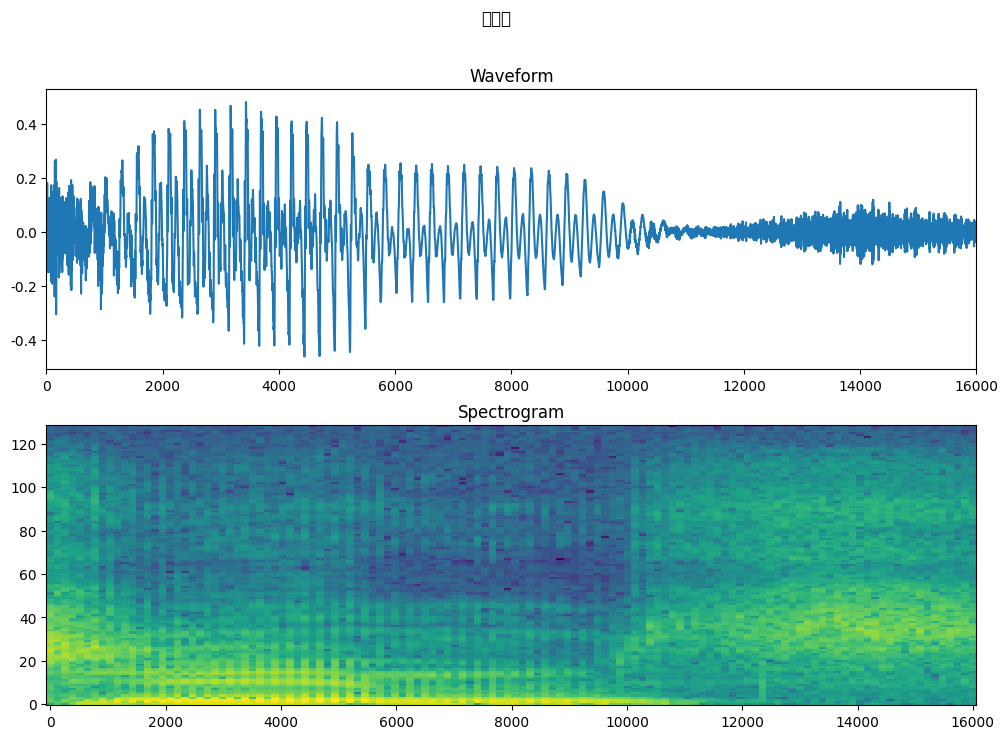

In [26]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [27]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [28]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [29]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

c:\Users\Bereket\Desktop\project\env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 4632 (\N{ETHIOPIC SYLLABLE MA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Bereket\Desktop\project\env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 4661 (\N{ETHIOPIC SYLLABLE SE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Bereket\Desktop\project\env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 4704 (\N{ETHIOPIC SYLLABLE BA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Bereket\Desktop\project\env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 4709 (\N{ETHIOPIC SYLLABLE BE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Bereket\Desktop\project\env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 4608 (\N{ETHIOPIC SYLLABLE HA}) missing from current font.
  fig.c

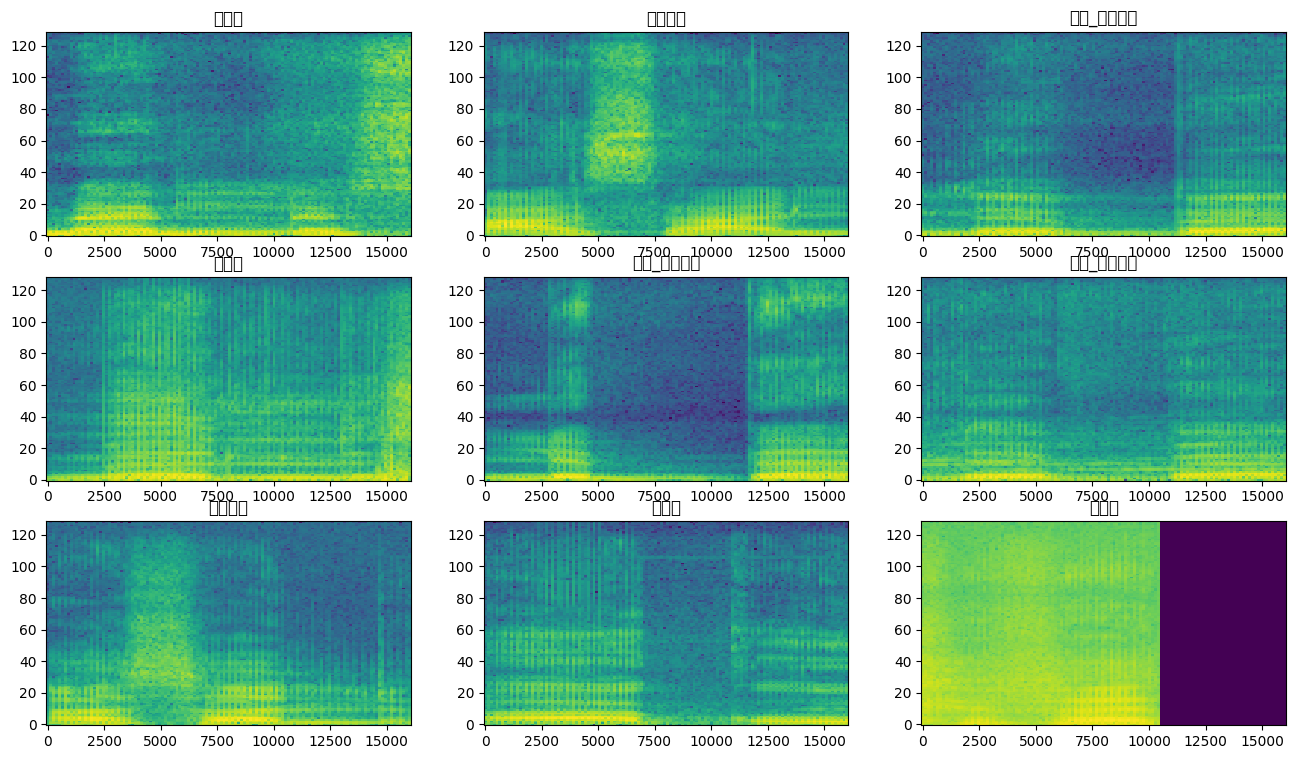

In [30]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [31]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [32]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

In [33]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [34]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
3/3 [==============================] - 2s 191ms/step - loss: 2.2703 - accuracy: 0.1838
Epoch 2/10
3/3 [==============================] - 0s 151ms/step - loss: 2.0202 - accuracy: 0.2941
Epoch 3/10
3/3 [==============================] - 0s 135ms/step - loss: 1.7372 - accuracy: 0.4926
Epoch 4/10
3/3 [==============================] - 0s 130ms/step - loss: 1.4636 - accuracy: 0.5074
Epoch 5/10
3/3 [==============================] - 0s 136ms/step - loss: 1.1780 - accuracy: 0.6103
Epoch 6/10
3/3 [==============================] - 0s 141ms/step - loss: 1.0349 - accuracy: 0.7059
Epoch 7/10
3/3 [==============================] - 0s 136ms/step - loss: 0.9103 - accuracy: 0.7574
Epoch 8/10
3/3 [==============================] - 0s 174ms/step - loss: 0.7004 - accuracy: 0.8088
Epoch 9/10
3/3 [==============================] - 0s 177ms/step - loss: 0.5405 - accuracy: 0.8529
Epoch 10/10
3/3 [==============================] - 0s 136ms/step - loss: 0.4851 - accuracy: 0.8382


KeyError: 'val_loss'

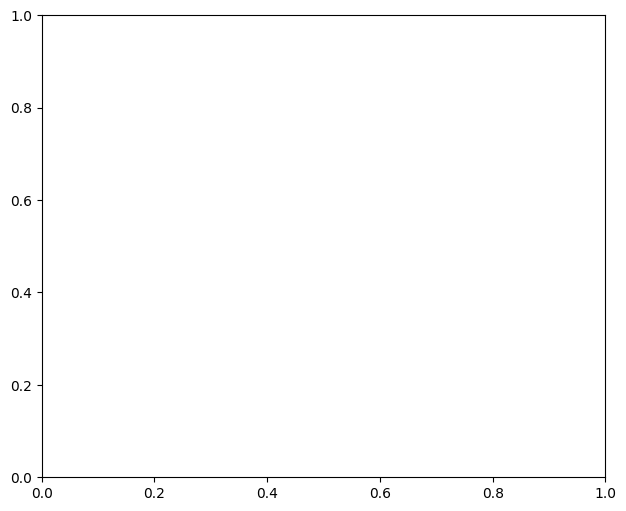

In [35]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [36]:
model.evaluate(test_spectrogram_ds, return_dict=True)

1/1 [==============================] - 1s 518ms/step - loss: 1.7290 - accuracy: 0.5882


{'loss': 1.7290047407150269, 'accuracy': 0.5882353186607361}

In [37]:
y_pred = model.predict(test_spectrogram_ds)

1/1 [==============================] - 0s 125ms/step


In [38]:
y_pred = tf.argmax(y_pred, axis=1)

In [39]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

c:\Users\Bereket\Desktop\project\env\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 4621 (\N{ETHIOPIC SYLLABLE LE}) missing from current font.
  fig.canvas.draw()
c:\Users\Bereket\Desktop\project\env\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 4704 (\N{ETHIOPIC SYLLABLE BA}) missing from current font.
  fig.canvas.draw()
c:\Users\Bereket\Desktop\project\env\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 4709 (\N{ETHIOPIC SYLLABLE BE}) missing from current font.
  fig.canvas.draw()
c:\Users\Bereket\Desktop\project\env\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 4653 (\N{ETHIOPIC SYLLABLE RE}) missing from current font.
  fig.canvas.draw()
c:\Users\Bereket\Desktop\project\env\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 4608 (\N{ETHIOPIC SYLLABLE HA}) missing from current font.
  fig.canvas.draw()
c:\Users\Bereket\Desktop\project\env\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 4757 (\N{ETHIOPIC SYLLABLE NE}) mis

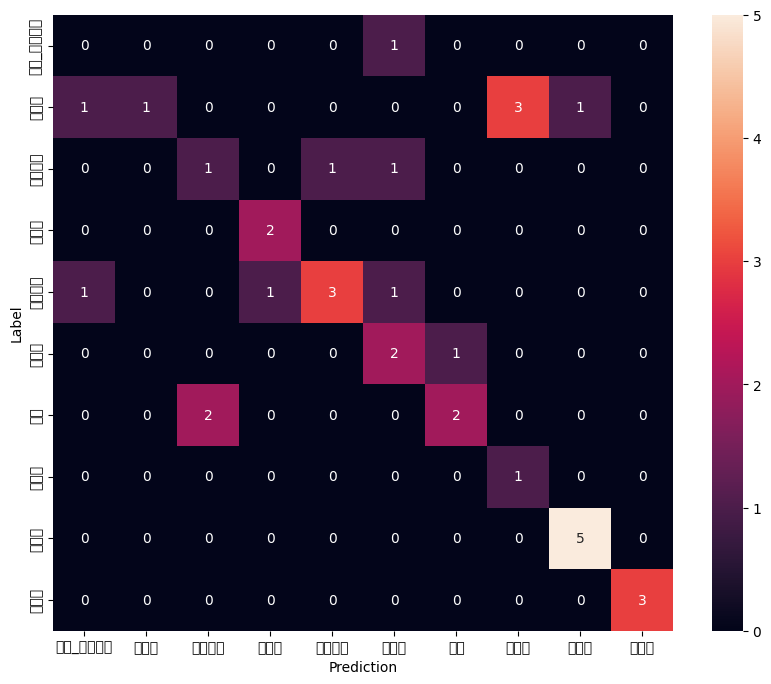

In [40]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

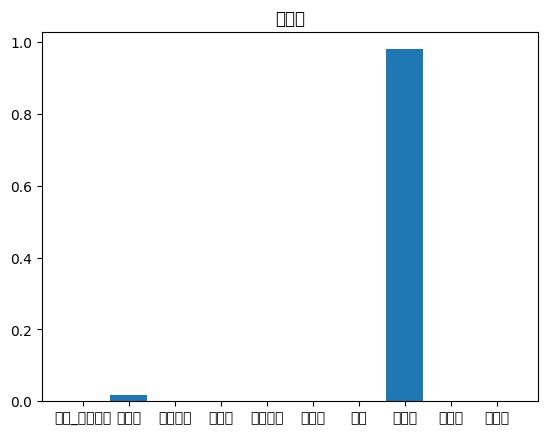

In [41]:
x = data_dir/'መልስ/መልስ.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['ልበ_ብርሀን','መልስ','አሳልፍ','አቁም','አቋርጥ','ክፈት','ዝጋ','ድምፅ','ጀምር','ፅሁፍ']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('መልስ')
plt.show()

display.display(display.Audio(waveform, rate=16000))

In [ ]:
model.save("saved_model") 

In [43]:
loaded_model = models.load_model("saved_model")

c:\Users\Bereket\Desktop\project\env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 4632 (\N{ETHIOPIC SYLLABLE MA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Bereket\Desktop\project\env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 4621 (\N{ETHIOPIC SYLLABLE LE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Bereket\Desktop\project\env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 4661 (\N{ETHIOPIC SYLLABLE SE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Bereket\Desktop\project\env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 4704 (\N{ETHIOPIC SYLLABLE BA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Bereket\Desktop\project\env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 4709 (\N{ETHIOPIC SYLLABLE BE}) missing from current font.
  fig.c

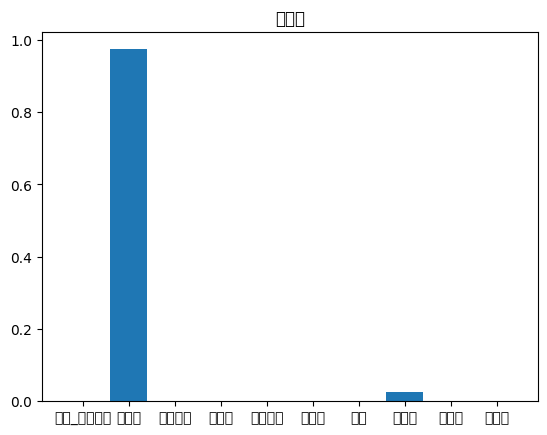

In [44]:
prediction = loaded_model(x)
x_labels = ['ልበ_ብርሀን','መልስ','አሳልፍ','አቁም','አቋርጥ','ክፈት','ዝጋ','ድምፅ','ጀምር','ፅሁፍ']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('መልስ')
plt.show()

display.display(display.Audio(waveform, rate=16000))